![Knot mesh with details removed](knot.png)

> Knot mesh with details removed using a low pass filter.

> Mesh credit: https://www.thingiverse.com/thing:2312901

# Nonlinear Spectral Geometry Processing via the TV Transform

In [313]:
import numpy as np
import cvxpy as cp
import scipy as sp
import scipy.optimize
import matplotlib.pyplot as plt

from PIL import Image

Thank you for reviewing our submission. We present a comprehensive review of the following paper:

> Marco Fumero, Michael Möller, and Emanuele Rodolà. 2020. Nonlinear Spectral Geometry Processing via the TV Transform. ACM Trans. Graph. 39, 6, Article 199 (December 2020), 16 pages. https://doi.org/10.1145/3414685.3417849

This was a challenging paper to implement, hence we will spend some time in this report developing an understanding of the mathematical background. Our report has the following structure:

- An introduction to Total Variation
- An outline of the key contribution of the paper
- The results of our implementation in Python
- A critical evaluation of both our results and the results of the paper

### Teamwork

My contributions to the project were:

- Providing an existing general mesh processing framework in python, developed as part of Coursework 2.
- Implementing the Primal-Dual Hybrid Gradient for **normal fields**
- An interface to experiment with removing details from meshes through the use simple filters.

My partner contributed:

- Various operators used for decomposition and reconstruction of results
- Implementing the Primal-Dual Hybrid Gradient for **scalar fields**
- An interface for experimenting with removing details from scalar functions on meshes.

We do not use any libraries for mesh processing beyond `numpy` and `scipy`. Mesh visualization in this report is handled by `meshplot`[2]. We additionally found the authors' original code, written in Matlab, which we referenced to triage some challenging aspects of the implementation [1].

In this report, I have chosen to focus specifically on the spectral decomposition of **normal fields**. My partner, Tsz Lam, has created a similar framework for exploring the decomposition of **scalar fields**. Our code is available on GitHub[3].

[1] https://github.com/marc0git/SpecTVSurface/

[2] https://github.com/skoch9/meshplot

[3] https://github.com/gheylam/SpectralMeshProcessing/

## Background & Summary


### Signal Processing

To understand this work in a broader context, it is useful to first understand Total Variation. Consider the total variation of a 1D signal $x$, which we can define as:

$$
\text{TV}(x) = \sum_n|{x_{n+1} - x_{n}}|
$$

Below I plot an example of a true signal $x$ which has been corrupted by gaussian white noise during measurement, resulting in the measurement $y$. We additionally plot the variation of the signal $y$. This captures the noise, and additionally captures the sharp jumps caused by changes in the signal.

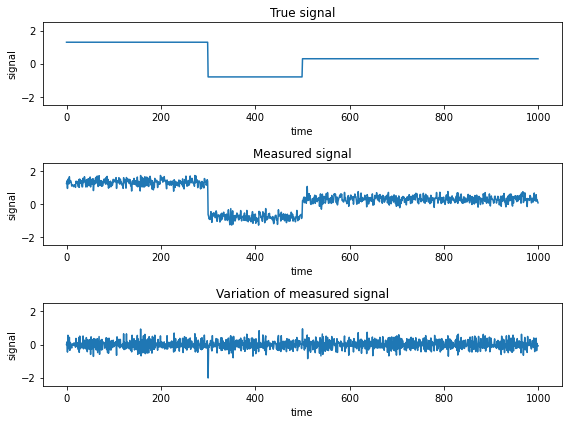

In [610]:
t = np.arange(0, 1000)
x = np.array([1.3] * 300 + [-0.8] * 200 + [0.3] * 500)
y = x + np.random.randn(1000) * 0.2

fig, axs = plt.subplots(3, figsize=(8, 6))
data = [
    ("True signal", x),
    ("Measured signal", y),
    ("Variation of measured signal", np.diff(y, prepend=y[0])),
]
for i, ax in enumerate(axs):
    title, ys = data[i]
    ax.set_title(title)
    ax.plot(t, ys)
    ax.set_ylim([-2.5, 2.5])
    ax.set_xlabel('time')
    ax.set_ylabel('signal')
fig.tight_layout()
plt.show()

For a 1D signal, observe that the variation in the signal shows a sharp peak at large discontinuities in the signal. We can use the total variation (the sum of the absolute variation) as a regularization term in a least squares solution:

$$
\min_x \leftarrow \sum_{n}\left(y_{n} - x_{n}\right)^{2} + t \cdot t{TV}(x)
$$

Unlike ordinary least squares, no closed form solution exists for this minimization problem. This is specifically because the $\mathscr{l_1}$ norm present in TV regularization is continuous, but is not smoothly differentiable due to a "kink" in the graph of $y = |x|$.

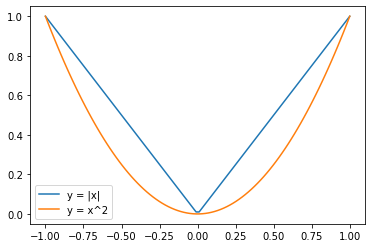

In [315]:
x = np.linspace(-1, 1, 100)
plt.plot(x, np.abs(x), label="y = |x|")
plt.plot(x, x ** 2, label="y = x^2")
plt.legend()
plt.show()

Note that both the data fidelity term and the regularization penalty are both convex functions. This does not make the problem easier, but it does imply that a unique global solution exists.

Convex optimization is an extremely broad topic. *Nesterov, Y., 2018. Lectures on convex optimization (Vol. 137). Cham: Springer.* Provides an excellent introduction, as do the works of Professor Stephen Boyd. For the purpose of this review, we provide the following facts without proof:

- We define a convex optimization problem as a problem where every local minimum is a global minimum
- Different numerical methods exist for solving different classes convex optimization problems
- Convex optimization problems are classified by: Their constraints, whether they have any smooth or non-smooth components, and whether or not the objective function is *strictly* convex (there exists only one global minimum).

An algorithm which shows promise at solving a broad-class of nonsmooth convex optimization problems is the Primal-Dual Hybrid Gradient method, first proposed here:

> Antonin Chambolle, Thomas Pock. A first-order primal-dual algorithm for convex problems with applications to imaging. 2010. hal-00490826

We briefly introduce this method as a means to solving this problem.

### Primal-Dual Hybrid Gradient Method

Abbreviated PDHG, this is a method which can solve convex optimization problems of this form:

$$
\min_{x} F(K x)+G(x)
$$

Where $F$ and $G$ are proper convex, lower semicontinuous functions, and $K$ is a linear operator. This problem has the following primal-dual formation:

$$
\min_{x} \max_{y}\langle K x, y\rangle+G(x)-F^{*}(y)
$$

Where $F^*$ is the convex conjugate of $F$. The Primal-Dual Hybrid Gradient algorithm is described below:

> **Primal Dual Hybrid Gradient**
>
> Algorithm 1 in Chambelle, Pock 2010
> - Initialization: Choose $\tau, \sigma>0, \theta \in[0,1],\left(x^{0}, y^{0}\right)$ and set $\bar{x}^{0}=x^{0}$
> - Iterations $(n \geq 0)$ : Update $x^{n}, y^{n}, \bar{x}^{n}$ as follows:
> $$
\left\{\begin{array}{l}
y^{n+1}=\left(I+\sigma \partial F^{*}\right)^{-1}\left(y^{n}+\sigma K \bar{x}^{n}\right) \\
x^{n+1}=(I+\tau \partial G)^{-1}\left(x^{n}-\tau K^{*} y^{n+1}\right) \\
\bar{x}^{n+1}=x^{n+1}+\theta\left(x^{n+1}-x^{n}\right)
\end{array}\right.
$$

Where $\partial F*$ and $\partial G$ are the subgradients of $F*$ and $G$, and $\left(I+\sigma \partial F^{*}\right)^{-1}$ is the proximal operator of $F^*$. We refer the reader to the Chambelle and Pock 2010 for the derivations and proofs of these operators, as there is simply too much to cover here.

Below we show the results of expressing our TV denoising problem in this form, and show the results of applying this algorithm to our 1D signal.

In [1388]:
x = np.array([1.3] * 300 + [-0.8] * 200 + [0.3] * 500)
y = x + np.random.randn(1000) * 0.2

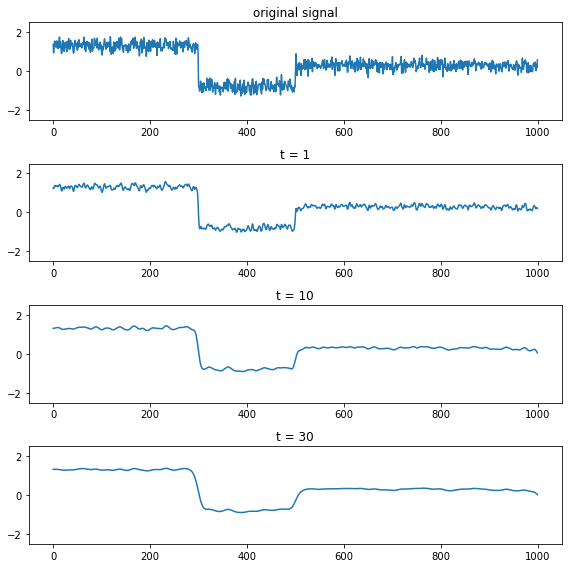

In [1584]:
def dy(x):
    # first order difference along x axis
    return np.diff(x, 1, 0, append=0)


def dy_t(x):
    # adjoint of first order difference along y axis
    return -np.diff(x, 1, 0, prepend=0)


def dx(x):
    # first order difference along y axis
    return np.diff(x, 1, 1, append=0)


def dx_t(x):
    # adjoint of first order difference along x axis
    return -np.diff(x, 1, 1, prepend=0)


def pdhg_tv_l2(u, t):

    def grad(x):
        return dy(x)
    
    def div(x):
        return dy_t(x)
    
    def spectral_radius(shape):
        # estimate the spectral radius of K
        x = np.random.randn(*shape)
        transform = div(grad(x))
        radius = np.linalg.norm(transform) / np.linalg.norm(x)
        return 2 / radius
    
    L = spectral_radius(u.shape)
    # tau controls the step size
    tau = np.sqrt(L)
    # sigma should be automatically set to guarantee convergence
    sigma = L / tau
    # this gets weird
    gamma = 1 / (t + 1e-10)
    
    # primal
    x = np.zeros_like(u)
    # dual
    y = np.zeros_like(u)
    # extrapolation
    z = np.zeros_like(u)
    
    def prox_f(x):
        # simple pointwise quadratic problem
        return (x + gamma * tau * u) / (1 + gamma * tau)

    def prox_g(x):
        # projection of l1 norm
        return np.maximum(np.abs(x), 0) * np.sign(x)
    
    for i in range(0, 100):
        # dual update (tv regularization)
        y = prox_g(y + sigma * grad(z))
        # primal update (data fidelity term)
        x_prev = x
        x = prox_f(x - tau * div(y))
        # extrapolation
        z = x + (x - x_prev)
    return x

fig, ax = plt.subplots(4, figsize=(8, 8))
ax[0].set_title(f"original signal")
ax[0].set_ylim([-2.5, 2.5])
ax[0].plot(y)
ax[1].set_title(f"t = 1")
ax[1].set_ylim([-2.5, 2.5])
ax[1].plot(pdhg_tv_l2(y, 0.01))
ax[2].set_title(f"t = 10")
ax[2].set_ylim([-2.5, 2.5])
ax[2].plot(pdhg_tv_l2(y, 0.1))
ax[3].set_title(f"t = 30")
ax[3].set_ylim([-2.5, 2.5])
ax[3].plot(pdhg_tv_l2(y, 0.3))
plt.tight_layout()
plt.show()

Note that we have a parameter, $t$, which weights the total variation against the data fidelity term. We see that smaller values of $\alpha$ decrease the data fidelity in exchange for minimizing the total variation in the signal.

### Image Processing

Having implemented the PDHG algorithm, we can easily show the results of TV denoising in the context of image processing. Below I show the results of PDHG with TV regularization for images, using the method described in Chambelle & Pock 2010.

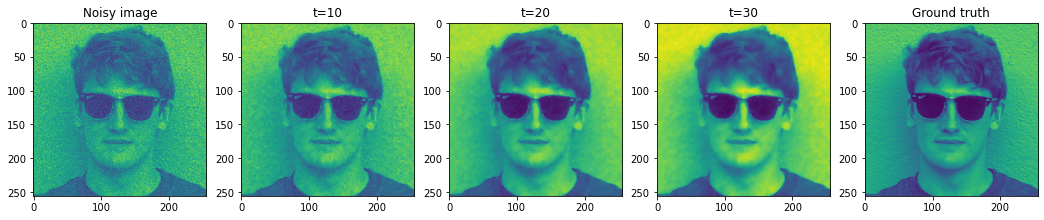

In [1483]:
def pdhg_tv_l2_img(u, t):
    
    xs, ys = u.shape

    def grad(x):
        g = np.zeros((256, 256, 2))
        g[:, :, 0] = dx(x)
        g[:, :, 1] = dy(x)
        return g
    
    def div(x):
        return (dx_t(x[:, :, 0]) + dy_t(x[:, :, 1]))
    
    def spectral_radius(shape):
        # estimate the spectral radius of K
        x = np.random.randn(*shape)
        transform = div(grad(x))
        radius = np.linalg.norm(transform) / np.linalg.norm(x)
        return 2 / radius
    
    L = spectral_radius(u.shape)
    # tau controls the step size
    tau = np.sqrt(L)
    # sigma should be automatically set to guarantee convergence
    sigma = L / tau
    # always 1 for some reason
    theta = 1
    
    gamma = 1 / (t + 1e-6)
    
    # primal
    x = np.zeros((xs, ys))
    # dual
    y = np.zeros((xs, ys, 2))
    # extrapolation
    z = np.zeros_like(x)
    
    def prox_f(x):
        # simple pointwise quadratic problem
        return (x + gamma * tau * u) / (1 + gamma * tau)

    def prox_g(z):
        # project primal onto the L2 ball
        # np.maximum preserves points that are already inside the ball
        x = z[:, :, 0]
        y = z[:, :, 1]
        norm = np.sqrt(np.maximum(x * x + y * y, 1))
        z[:, :, 0] = x / norm
        z[:, :, 1] = y / norm
        return z
    
    for i in range(0, 100):
        # dual update (tv regularization)
        y = prox_g(y + sigma * grad(z))
        # primal update (data fidelity term)
        x_prev = x
        x = prox_f(x - tau * div(y))
        # extrapolation
        z = x + (x - x_prev)
    return x

img = np.array(Image.open('oli256.png').convert('L'))
noisy = img + np.random.randn(256, 256) * 20

fig, ax = plt.subplots(1, 5, figsize=(18, 4))

ax[0].imshow(noisy)
ax[0].set_title("Noisy image")
for i in range(1, 4):
    t = i * 10
    ax[i].set_title(f"t={t}")
    ax[i].imshow(pdhg_tv_l2_img(noisy, t))
ax[4].imshow(img)
ax[4].set_title("Ground truth")
plt.show()

We can see that the TV regularization "flattens" our image, removing noise but additionally removing detail in areas that are not sharp edges. We will see the same effect once we implement TV regularization for meshes.

## Contribution of the Paper

The paper begins by introducing total variation minimization for signals across manifolds. Specifically, they provide a technique for minimizing

$$
E(u)=\frac{1}{2} \int_{\mathcal{M}}\left(u(x)-u_{0}(x)\right)^{2} d x+t \cdot \text{TV}(u), \quad t>0
$$

where $u$ is a signal across the surface of our mesh $x$. They then show that stacking reconstructions at varying levels of $t$ yields a novel framework for spectral decomposition on manifolds.

To understand how this works, consider the effect of varying $t$ above. Increasing values of $t$ add more weight to our TV regularization, whereas decreasing values of $t$ preserve an accurate reconstruction of the underlying signal.

The authors reason that by minimizing signals across our mesh with a varying $t$, we can decompose our mesh into spectral bands, where each band represents a level of detail in the reconstruction. Below shows a key image from the publication: We can see that a low-pass filter can be used to remove fine details from a mesh.

![Spectral Bands of a knot mesh](star.png)

Concretely, consider a mesh with $|V|$ vertices and $|F|$ faces. For any signal across the mesh, we decompose it into $|F| \times t$ spectral bands, with each band representing a specific level of $TV$ regularization.

The authors describe $t$ as the "time" domain as the decompositions are additive - that is, the first spectral bands have been filtered with the highest $t$, and subsequent spectral bands filter the mesh with lower $t$. As $t$ decreases, the reconstruction becomes converges to the original mesh.

In my opinion, the main contribution of this paper is that the authors have used TV regularization for meshes as the basis for a spectral decomposition framework. The ability to separate any function of a mesh into spectral bands that can be analyzed, enhanced, or removed is incredibly powerful.

They additionally propose a number of interesting extensions and novelties:

1. Using a low-pass filter, we can selectively remove details from meshes, as above. This provides a pretty good solution to the classical mesh denoising problem
2. In theory, we can transfer sharp geometric details across meshes, even when the number of vertices and faces are different
3. Using different filters, we can selectively enhance and downgrade fine details of a mesh

As we explain the results of our implementation, we will encounter and examine the limitations of this approach.

## Implementation

Using the Primal-Dual Hybrid Gradient algorithm, we iteratively minimize the total variation of a function across our mesh to construct a forward transform to the spectral domain.

The paper describes specific functions across meshes that we can consider minimizing:

1. Indicator functions on different regions - such as colors provided by a texture or map
2. Coordinate functions
3. Normal fields

I will focus on my main contribution to the project, which is the decomposition of a meshes **normal field** into different spectral bands. In this case, the signal $u$ which we wish to minimize is the total variation across the normals of our mesh faces. Below we provide the steps required for implementation.

#### Choose a function to Minimize

We wish to minimize the total variation of the normal field of our mesh. The normal field is easily computed by taking the cross product of every edge, ensuring a correct winding order such that the normals face outwards. Below we show our normal field as a colored mesh, with our normals projected onto the euclidian ball.

![Knots and normals](normals.png)

#### Compute the Gradient and the Adjoint

Our normal field is not very interesting - what we are really interested in is how our normals change over the surface of our mesh. After all it is this variation which we are seeking to minimize. Appendix B.3. of Fumero et al provides details of the edge-based gradient.

In a discrete setting, our gradient operator $G$ is an $|E| x |F|$ sparse adjacency matrix. It operates on our normal field of size $|F|$, and returns the jump in discontinuity across edges that are shared by neighboring triangles. As an edge is only ever shared by a pair of triangles, the jump discontinuity across the edge is $1$ or $-1$ depending on the winding order of the vertices in the corner table. Therefore, each row of this sparse matrix sums to 0.

Our divergence operator (the adjoint of the gradient) is computed as:

$$
\mathbf{D}_{e}=-\mathbf{G}_{e}^{\top} \mathbf{A}_{e}
$$

where $A_{e}$ is the diagonal matrix of edge lengths.

#### Construct Proximal Operators

The primal-dual hybrid gradient method requires proximal operators to be defined. Briefly, these operators project our primal and dual variables onto their respective convex sets. A solution is found when our primal and dual variables are sufficiently close to one another within the range of their constraints.

The proximal operator of the primal variable $\operatorname{prox}_{\mathcal{G}}$ has the following closed form solution:

$$
\operatorname{prox}_{\mathcal{G}}(\mathbf{u})=\frac{\mathbf{u}+\frac{\tau}{\alpha} \mathbf{u}_{0}}{1+\frac{\tau}{\alpha}}
$$

The proximal operator of the dual variable is the projection of the dual update onto the unit $L^2$ ball:

$$
\operatorname{prox}_{\mathcal{F}^{*}}\left(\mathbf{q}_{j,:}\right)=\left\{\begin{array}{ll}
\mathbf{q}_{j,:} & \left\|\mathbf{q}_{j,:}\right\| \leq 1 \\
\frac{\mathbf{q}_{j,:}}{\left\|\mathbf{q}_{j,:}\right\|} & \text { otherwise }
\end{array}\right.
$$

We note that these projections are identical to those used in the image denoising case as shown in Chambelle & Pock, 2009. Intuitively, this is because the total variation over a normal field is related to the soft-thresholding operator, which is the proximal mapping of the $l_1$ norm.

#### Convergence

Recall that for each time-step, we wish to increase the weighting of our TV regularisation term. In practice, this is acheived through a variable $\alpha$ which decreases the weighting of the data fidelity term

$$
u(t) \longleftarrow \min _{u} \text{TV}(u)+\frac{1}{2 \alpha}\left\|u-u_{0}\right\|_{2}^{2}
$$

At $t=0$, alpha is initialized to be very high, which reduces the weighting of the data fidelity term. For each time-step, we decrease $\alpha$ by around 80% so as to continually increase the weighting of the data fidelity term, adding detail. The below graph shows how decreasing $\alpha$ results in removing different levels of detail from our mesh. The below plot shows the norm of the change in spectrum against the value of alpha. Observe that the derivative of the spectrum is 0 at locations where subsequent values of alpha achieve the same result. This means that the spectral band is identical to the previous band for the choice of $\alpha$.

![Alpha regularization](alphas.png)

In the case of our knot mesh, we can see that the features are localized around a handful of values of $\alpha$. We will see how the choice of $\alpha$ affects the spectrum of our knot mesh when we explore the results in more detail.

#### Reconstruction

After the PDHG algorithm has converged, we are left with an array of $t$ normal fields. The last step to reconstructing a mesh is to reconstruct the derivative of our normal fields back into our original mesh.

We perform the reconstruction using the provided equation:

$$
\mathbf{v}=(\epsilon \mathbf{A}-\mathbf{L})^{-1}\left(\epsilon \mathbf{A} \mathbf{v}_{0}-\mathbf{D} \mathbf{w}\right)
$$

Here, $L$ is the laplace-beltrami operator, $v_0$ are our original vertices, and $w$ is the sum of the normal fields that we wish to compute as part of the reconstruction.

## Results

The authors present an enormous list of things that are achievable with this framework. I present the results I was able to acheive here.

### Filtering

Below I show the simple interface that I have designed which allows me to run a zero-pass filter across a choice of frequency bands.

![Interface](interface.png)

Below, we zoom into the mesh to show some details being removed:

![Spectral interface](shrinkage.png)

An interactive slider allows you to flatten the spectral bands of the mesh. As I drag the filter from right to left, it acts as a low pass filter, zeroing some of the bands, and some of the features of the mesh as a result.

We can see that for the knot mesh, dragging the slider to the left progressively eliminates the ridge details. The full reconstruction represents a perfect reconstruction of the original mesh. The intermediate reconstructions are interesting. It appears that one of the spectral bands has reduced the total variation between the apex and the base of the pyramids.

#### Classical Denoising

In addition to selecting feature bands, it's worth noting that this framework can additionally perform mesh denoising. Below we compare the results of denoising the Fandisk model in Coursework 2 against this approach. On the left is the orignal mesh, center is explicit mesh denoising using the Laplace Beltrami operator ($\lambda = 0.001$), and on the right is the result of TV denoising by reconstructing with just the first 2 eigenvectors.

![Explicit Laplacian denoising vs TV Denoising](fandisk.png)

We can see how the denoising based on mean curvature has produced a smooth result. In contrast, the first few eigenvectors of our spectral TV decomposition have produced sharper edges more suitable for a CAD model.

#### Detail Enhancement

Finally, another obvious application of having separated our spectral bands is to pick specific bands for enhancement. Below I show the results of scaling some of the feature bands to enhance the details on the bust of Sappho.

The UI has two sliders: One selects the band of details for enhancement, and the other allows you to relatively scale that band. Simply multiplying the spectral band is sufficient for enhancing details in a given mesh. Observe how the norm of our feature bands in the below graph are appropriately scaled with the slider. Notice how Sappho is shrunk as a result of scaling detail, which seems undesirable, but could be addressed in this case by restandardizing the mesh to a unit cube.

![Detail Enhancement](details.png)

Selectively enhancing specific components can give some interesting stylistic effects. Below, I explore the frequency bands by massively scaling the signal at specific bands. This produces some unusual, but visually pleasing, results. This highlights a key limitation of this framework, which is that it is very difficult to intuit what lies within each frequency bands.

![Scaling frequency bands](scaling.png)

## Conclusion & Critique

### Limitations of our Implementation

My implementation is limited compared to what is possible with the framework as presented in the original paper. Firstly, I am only able to evaluate the normal geometric flow across the whole mesh. If we had a "brush" which we could use to select faces, we would be able to remove features from specific parts of the mesh. As all faces of the mesh rely on the same forward transform and inverse transform, this would be simple to achieve with the right UI.

We were unsuccessful in transferring sharp geometric details across meshes. While two meshes are not required to have the same number of vertices and faces, they do need to be at similar scales. We are confident we could achieve this with more time and access to meshes which are similar in scale space.

### Limitations of the Approach

Firstly, before meshes go through the spectral decomposition framework, they must be normalized and scaled to fit within a unit cube.

Weird scaling issues additionally occur during reconstruction - when interacting with the zero-pass filter, parts of the mesh are exaggerated as different bands are flattened. We have made this more noticable due to the interactive nature of our approach. Consider the results of a zero-pass filter on the Gargoyle, below. As we remove spectral bands, some perplexing problems begin to appear:

The bottom jaw of the Gargoyle is shrunk - but only up to a point - it is never removed entirely. Why is the bottom jaw specifically removed compared to say, the wings?

![Gargoyle reconstruction](gargoyle.png)

This is made all the more perplexing when looking at a mesh with significantly more detail. Below we present the spectral TV decomposition of the bust of Sappho. We can see that at the lower end of the reconstruction, many of her features are still preserved. Why are the Gargoyle's nose and ears diffused, sometimes only partially, but the nose of Sappho is preserved?

![Sappho reconstruction](sappho.png)

The authors note that choosing a schedule for $\alpha$ is the biggest limitation in this approach. In my opinion, the bigger issue is that it's not currently intuitive to reason about what counts as a "feature". Scaling $\alpha$ allows you to diffuse features across spectral bands, but it does not seem to change the features that are specifically selected for minimization.

### Conclusion

This work has been exciting and challenging. The key challenges were:

- Understanding the relevant background in convex optimisation and its applications to signal processing. It was specifically difficult to understand why so many different numerical methods exist, why PDHG is chosen, the role of proximal operators and of the Lagrangian Dual formulation.
- Efficiently constructing a wide array of different operators to use.

This is not a learned method, and is instead based on a physical model. In image processing, there is a lot of promise in combining physical models with learned methods. It would be interesting to compare convex optimisation with learned methods for mesh feature selection and denoising.

TV regularisation has potential to be a very useful tool for mesh processing, and the framework presented here is just one approach of utilizing it. It would be exciting to see if other inverse problems beyond denoising can be solved using a similar approach - such as inpainting and the transfer of larger geometric features.

---